# ADVANTAGES OF PORTABLE-ALPHA STRUCTURES

## `import`s

In [17]:
from __future__ import annotations

from typing import Final

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

import foggy_statslib.core as fc

## What is portable alpha?

Say our universe consists of three stocks, A, B, and C, with A twice as large and half as volatile as B or C. Don't worry about the math setup in this part, the details are not important. But I've copy-pasted a bunch of utility functions that are more fleshed-out [here](https://github.com/sparshsah/foggy-statslib/blob/main/foggy_statslib/fin.py) so that interested readers can play with the numbers.

In [44]:
MKT_CAP: Final[pd.Series] = pd.Series({"A": 1_000, "B": 500, "C": 500})
BMK: Final[pd.Series] = MKT_CAP / MKT_CAP.sum()
VOL: Final[pd.Series] = pd.Series({"A": 0.10, "B": 0.20, "C": 0.20})
CORR: Finall[pd.DataFrame] = pd.DataFrame(
    {
        "A": {"A": 1, "B": 0.50, "C": 0.50},
        "B": {"A": 0.50, "B": 1, "C": 0.90},
        "C": {"A": 0.50, "B": 0.90, "C": 1},
    }
)
COV: Final[pd.DataFrame] = (
    pd.DataFrame(np.diag(VOL), index=VOL.index, columns=VOL.index)
    @ CORR
    @ pd.DataFrame(np.diag(VOL), index=VOL.index, columns=VOL.index)
)

def _get_pflio_cov(w_a: pd.Series, w_b: pd.Series = BMK) -> float:
    return w_a @ COV @ w_b

def _get_pflio_vol(w: pd.Series = BMK) -> float:
    return _get_pflio_cov(w, w)**0.5

def _get_pflio_corr(w_a: pd.Series, w_b: pd.Series = BMK) -> float:
    cov = _get_pflio_cov(w_a=w_a, w_b=w_b)
    vol_a = _get_pflio_vol(w=w_a)
    vol_b = _get_pflio_vol(w=w_b)
    return cov / (vol_a * vol_b)

def _get_pflio_beta(w_of: pd.Series, w_on: pd.Series = BMK) -> float:
    corr = _get_pflio_corr(w_of, w_on)
    vol_of = _get_pflio_vol(w_of)
    vol_on = _get_pflio_vol(w_on)
    return corr * (vol_of / vol_on)

def _get_beta_part(w_of: pd.Series, w_on: pd.Series = BMK) -> float:
    beta = _get_pflio_beta(w_of=w_of, w_on=w_on)
    return beta * w_on

def _get_alpha_part(w_of: pd.Series, w_on: pd.Series = BMK) -> float:
    hedge = _get_beta_part(w_of=w_of, w_on=w_on)
    return w_of - hedge

def _decompose(w_of: pd.Series, w_on: pd.Series = BMK) -> float:
    d = pd.DataFrame(
        {
            "beta_part": _get_beta_part(w_of=w_of, w_on=w_on),
            "alpha_part": _get_alpha_part(w_of=w_of, w_on=w_on),
        }
    )
    d.loc[:, "sum"] = d.sum(axis="columns")
    return d

Think of two funds investing in this market:
* An index-tracking mutual fund, and
* A traditional beat-the-benchmark long-only stock-picking hedge fund (I already cringe at this name... how can you be long-only and also hedged... the whole point of a hedge fund used to be uncorrelated absolute returns...).

They might have holdings something like this:

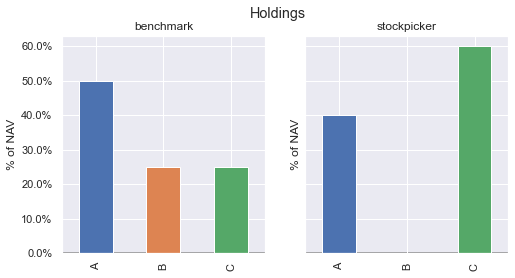

In [88]:
ww = pd.DataFrame(
    {
        "benchmark": BMK,
        "stockpicker": {"A": 0.40, "B": 0, "C": 0.60},
    }
)

_, ax = plt.subplots(ncols=len(ww.columns), sharex=True, sharey=True)
for (i, (f, w)) in enumerate(ww.items()):
    fc.plot(
        w,
        kind="bar",
        color=sns.color_palette(),
        ypct=True,
        ylabel="% of NAV",
        title=f,
        ax=ax[i],
        figsize=(4*len(ax), 4),
    )
plt.suptitle("Holdings")
plt.show()

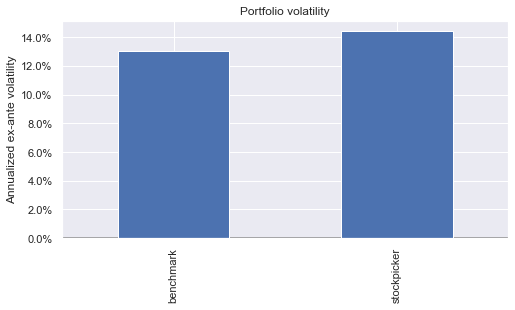

<AxesSubplot:title={'center':'Portfolio volatility'}, ylabel='Annualized ex-ante volatility'>

In [89]:
fc.plot(
    pd.Series(
        {
            f: _get_pflio_vol(w)
            for (f, w) in ww.items()
        }
    ),
    kind="bar",
    ypct=True,
    ylabel="Annualized ex-ante volatility",
    title="Portfolio volatility",
    figsize=(8, 4),
)

Now, let's decompose the stockpicker's holdings into two "parts":
* A long-only beta part, and
* An market-neutral long-short alpha part.

The two parts will sum together to exactly replicate the stockpicker's holdings.

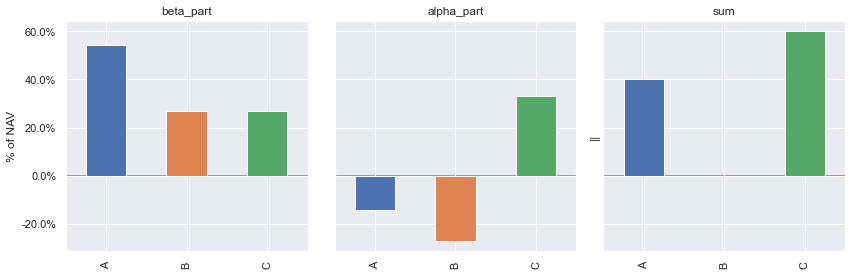

In [99]:
d = _decompose(ww["stockpicker"])
fig, ax = plt.subplots(ncols=len(d.columns), sharex=True, sharey=True)
for (i, (f, w)) in enumerate(d.items()):
    fc.plot(
        w,
        kind="bar",
        color=sns.color_palette(),
        ypct=True,
        # idk the why the middle plot's label gets hidden...
        ylabel={
            "beta_part": "% of NAV",
            "alpha_part": "+",
            "sum": "||",
        }[f],
        title=f,
        ax=ax[i],
        figsize=(4*len(ax), 4),
    )
fig.tight_layout()
plt.show()

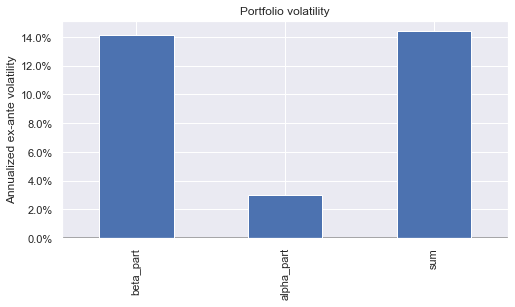

<AxesSubplot:title={'center':'Portfolio volatility'}, ylabel='Annualized ex-ante volatility'>

In [81]:
fc.plot(
    pd.Series(
        {
            f: _get_pflio_vol(w)
            for (f, w) in d.items()
        }
    ),
    kind="bar",
    ypct=True,
    ylabel="Annualized ex-ante volatility",
    title="Portfolio volatility",
    figsize=(8, 4),
)

Portable alpha is the idea that you should actually explicitly invest in two separate funds (even if managed by the same manager) according to the decomposition. Furthermore, the beta part should be a simple long-only investment into the index-tracking mutual fund.

For after all, if your manager claims that she's good at choosing stocks, doesn't that implicitly mean that she's good at predicting which stocks will perform better than others? Sounds like a relative-value bet to me!

## So, why portable alpha?

### Alpha opportunity-set expansion

You're no longer limited to finding relative-value opportunities just within the securities in your benchmark! Suppose  you're benchmarked to the S&P500. With an alphaport structure, your manager can look for relative-value opportunities in emerging stocks, or even in a totally different asset class like commodities!

(Yes, this exposes you to basis risk. I have my [own thoughts](https://github.com/sparshsah/foggy-demo/blob/main/demo/finance/basis-risk-bell-curve-meme.png) on that.)

### Control over market exposure

If you suddenly decide that you have a bad feeling about the economy, it's easy to close out your beta book without having to completely rethink your manager's investment strategy for you.

### Fair fees

Look at the portfolio volatilities. The "beta part" has annualized ex-ante vol of about 14%, whereas the alpha part has annualized ex-ante vol (AKA "tracking error") of only 3%. Together, the two have vol just over 14% (power of diversification!).

So most of the stockpicker's risk is just the beta part, which you could easily get by putting your money into a buy-and-hold passive index-tracking mutual fund or ETF! Why pay 2+20 for this?

Instead, get the beta part basically for free from some large institutional index-tracking mutual fund, and go back to your alpha manager and say "you're running just 3% of active risk for me, I'm fine paying you 20% performance fee but no way in hell I'm going to let you eat 2% management fee every year".

### Tax-loss harvesting

This is going to be a short illustration, but a much more in-depth analysis is ["The Tax Benefits of Separating Alpha and Beta" (Liberman-Sialm-Sosner-Wang 2018)](https://www.aqr.com/Insights/Research/Working-Paper/The-Tax-Benefits-of-Separating-Alpha-from-Beta).

Suppose next month your stockpicker's views change, and her new portfolio looks like this:

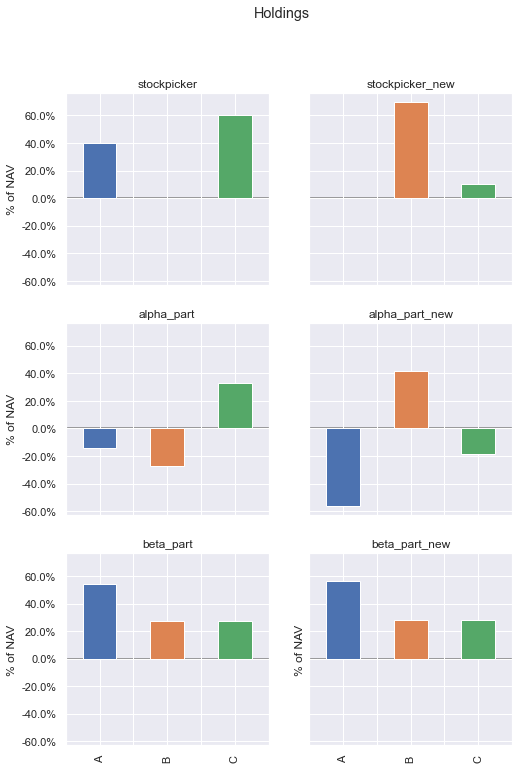

In [119]:
ww.loc[:, "stockpicker_new"] = pd.Series({"A": 0, "B": 0.70, "C": 0.10})
d_new = _decompose(ww["stockpicker_new"])

_, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
fc.plot(
    ww["stockpicker"],
    kind="bar",
    color=sns.color_palette(),
    ypct=True,
    ylabel="% of NAV",
    title="stockpicker",
    ax=ax[0, 0],
    figsize=(8, 12),
)
fc.plot(
    ww["stockpicker_new"],
    kind="bar",
    color=sns.color_palette(),
    ypct=True,
    ylabel="% of NAV",
    title="stockpicker_new",
    ax=ax[0, 1],
    figsize=(8, 12),
)
fc.plot(
    d["alpha_part"],
    kind="bar",
    color=sns.color_palette(),
    ypct=True,
    ylabel="% of NAV",
    title="alpha_part",
    ax=ax[1, 0],
    figsize=(8, 12),
)
fc.plot(
    d_new["alpha_part"],
    kind="bar",
    color=sns.color_palette(),
    ypct=True,
    ylabel="% of NAV",
    title="alpha_part_new",
    ax=ax[1, 1],
    figsize=(8, 12),
)
fc.plot(
    d["beta_part"],
    kind="bar",
    color=sns.color_palette(),
    ypct=True,
    ylabel="% of NAV",
    title="beta_part",
    ax=ax[2, 0],
    figsize=(8, 12),
)
fc.plot(
    d_new["beta_part"],
    kind="bar",
    color=sns.color_palette(),
    ypct=True,
    ylabel="% of NAV",
    title="beta_part_new",
    ax=ax[2, 1],
    figsize=(8, 12),
)
plt.suptitle("Holdings")
plt.show()

#### Mark-to-market profits

Stocks tend to go up on average, so let's say that every stock went up 1% over that month.

The stockpicker was unit-levered, so she made +1% that month. Great!

On the other hand, the alphaport manager:
* In the alpha part of her book, her +35% long-side leverage was exactly cancelled out by her -35% short-side leverage, so she was flat; But fortunately,
* In the beta part of her book, she was unit-levered, so still made her +1%.

Of course, that's the point, the net positions of the two were the same, so they made the same amount of money.

#### Short-term realized gains

But now let's examine the buying and selling from the two approaches.

The stockpicker sold off 40% of NAV in A and 50% of NAV in C. That's closing a long position of 90%, which means a short-term realized gain of +90bp.

On the other hand, the alphaport manager:
* Sold off her 30% position in C, closing a long position and realizing a gain of +30bp, and
* Closed her 25% short position in B, realizing a loss of -25bp.
* (Her short position in A actually got bigger, so there's no realized gain or loss here.)

That gives her a net short-term realized gain of +5bp. Meanwhile, her beta portfolio saw no activity, so that 1% mark-to-market profit she made there gets to just sit and age into long-term gains.

Let's annualize this. Over the next year, the stockpicker will realize a sequence of monthly short-term gains adding up to about +11%. Meanwhile, the alphaport manager will realize a sequence of monthly short-term gains adding up to about +60bps.

Wow! This was a tough year for stockpicking, since there wasn't really any dispersion in returns to exploit. But imagine how much worse the stockpicker's client will feel at the end of the year when they have to pay brutal short-term-gains taxes on that 11%! Meanwhile the alphaport client gets off pretty much scot-free.

## An example

What might an example application of an alphaport structure look like? Well, you could get your beta from Bridgewater's All-Weather Fund, and get your alpha from Citadel's Ashler Capital Fund.

So is there any downside to doing it this way, given that your two managers won't talk to each other? No, not really to any practical extent. But technically, yes, and for a discussion see the end of my [writeup on BRAT](https://github.com/sparshsah/foggy-demo/blob/main/demo/finance/brat.ipynb).

But it _can_ go wrong, if you act stupid! What do I mean? Well, two things.

* First of all, your leverage aversion. Your stockpicker will consistently be around 0.70-1.30x gross levered. Your alphaport manager, on the other hand, when summing across her books, will consistently run at 2x or more gross leverage. Sounds scary right? No! Summing gross leverages across books ignores the fact that her alpha book is extremely tightly-hedged. You already saw, the stockpicker's ex-ante portfolio volatility was just over 14%, but the risk from the alpha part was only 3%!

* Second of all, line-item reporting. Let's say the benchmark is up 20% this year and your stockpicker is up 10%. You're going to be mad, but not pissed. But now let's break out the line items. Your alphaport manager is up 20% in her  beta book, and _down_ -10% in her alpha book. What the fuck? You're pissed now! Underperforming the benchmark a bit you could forgive, but to use her so-called "skill" to literally actively lose the money that belonged to you and ruin what would otherwise have been a great year? Unbrookable! ... And I hope my sarcasm is clear.  But too many clients can't get over the human behavioral tendency to cringe at negative line items.